In [1]:
import random
import pickle
import string
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

import torch

from transformer_lens import HookedTransformer

%load_ext autoreload
%autoreload 2

/home/jgcarrasco/.virtualenvs/mech_interp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True
)

Loaded pretrained model gpt2-small into HookedTransformer


# New dataset
1. Take list of all 3-letter acronyms that are tokenized as three separate tokens (e.g. "|A|B|C|")
2. Take list of words that are tokenized as a single token (including their preceding space, e.g. "| Bruh|")
3. Create list of samples by (i) choosing and acronym and (ii) sampling a word from the previous list for every capital letter of the acronym (e.g. "|The| Auto| Bruh| Cafe|(|A|B|C|"). **NOTE:** We will sample the acronyms according to the frequency of the capital letters on our dictionary. We do this because, for example, there are a lot of acronyms containing the letter X but we have just one word beginning by X on our dictionary (as these are uncommon) thus uniformly sampling the acronyms would bring the word X a lot more than usual. 

In [3]:
acronyms_list = list(product(string.ascii_uppercase, repeat=3))
acronyms_list = ["".join(x) for x in acronyms_list]
len(acronyms_list)

17576

In [4]:
acronyms_tokenized = model.to_tokens(acronyms_list, prepend_bos=False)
# Take the indices of acronyms that are composed by 3 tokens, i.e. its last token is different from the BOS token
indices = torch.arange(acronyms_tokenized.shape[0], device="cuda")[acronyms_tokenized[:, -1] != 50256]
indices.shape

torch.Size([2740])

In [5]:
possible_acronyms_list = model.to_string(acronyms_tokenized[indices])
len(possible_acronyms_list), possible_acronyms_list[:5]

(2740, ['AJE', 'AJF', 'AJG', 'AJH', 'AJI'])

There are 2740 3-letter acronyms that are tokenized as three separate words. 

Now, let's collect a set of nouns that are tokenized as single tokens.

We will take the words from https://github.com/taikuukaits/SimpleWordlists/tree/master (Ashley Bovan page). It contains around **91k** nouns, so it should be sufficient (some of them are quite rare):

In [6]:
with open("data/nouns_1_token.txt", "w") as g:
    with open("data/Wordlist-Nouns-All.txt", "r") as f:
        for word in f.read().splitlines():
            word = " " + word.capitalize()
            str_word = model.to_str_tokens(word, prepend_bos=False)
            if len(str_word) == 1:
                g.write(word + "\n")

In [7]:
with open("data/nouns_1_token.txt", "r") as f:
    print(len(f.read().splitlines()))

6997


When filtering the nouns that are not tokenized as single tokens (including a preceding space) we drop from 91k to 7k. Now, to make it easier, we will build a dictionary that groups words beginning with the same capital letter:

In [8]:
# Initialize dictionary
words_dict = {}
for c in string.ascii_uppercase:
    words_dict[c] = []

n_words = 0
with open("data/nouns_1_token.txt", "r") as f:
    for word in f.read().splitlines():
        words_dict[word[1]].append(word)
        n_words += 1

with open('data/words_dict.pkl', 'wb') as f:
    pickle.dump(words_dict, f)

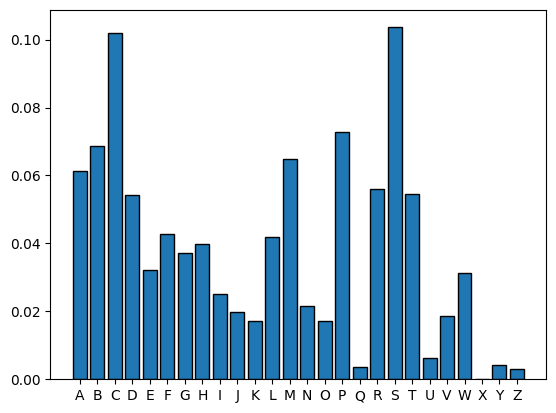

In [9]:
with open("data/words_dict.pkl", 'rb') as f:
        words_dict = pickle.load(f)

prob_dict = {}

n_words = sum([len(v) for _, v in words_dict.items()])

# get the probability of sampling a word beginning by each letter
for k, v in words_dict.items():
    prob_dict[k] = float(len(v)) / n_words

plt.bar(x=prob_dict.keys(), height=prob_dict.values(), edgecolor="black");

In [10]:
# probability distribution of the acronym list
p = np.array([prob_dict[acronym[0]]*prob_dict[acronym[1]]*prob_dict[acronym[2]] for acronym in possible_acronyms_list])
# normalize
p = p / p.sum()

In [11]:
def get_random_acronym(acronyms_list=possible_acronyms_list, words_dict_path="data/words_dict.pkl"):
    
    with open(words_dict_path, 'rb') as f:
        words_dict = pickle.load(f)

    acronym = np.random.choice(acronyms_list, size=1, p=p)[0]
    prompt = "The"
    for c in acronym:
        # Obtain a random word that meets the requirements
        word = random.choice(words_dict[c])
        prompt += word
    prompt = prompt + " (" + acronym[:2]
    return prompt, acronym

prompt, acronym = get_random_acronym()
prompt, model.to_string(model(prompt)[:, -1].argmax(-1))

('The Generations Jonathan Warsaw (GJ', ')')

Now that we have defined the sampling method, we will retrieve a list of 100000 samples.

In [12]:
i = 0
with open("data/acronyms.txt", "w") as f:
    while i < 10000:    
        prompt, acronym = get_random_acronym()
        f.write(prompt + ", " + acronym + "\n")
        i += 1